In [1]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
    
import geopandas as gpd

import numpy as np

import rasterio

from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import dask.dataframe as dd

import gc
import sys

from multiprocessing import Pool
import multiprocessing

from dask.diagnostics import ProgressBar

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Weather Data
Do this across all zips, for the establishment records. We'll put this into a different format right after, and then change the columns and whatnot. 

Before we had done this specifically for the hq zips, which changed our "annual" thresholds, which are taken over all zipcodes in the sample. The zip-specific definitions are the same, though.

In [5]:
allWeather = pd.read_csv("../../data/companyData/revised_allWeatherBins_2000to2019_allZips.csv").\
    drop(columns = {"Unnamed: 0"}).rename(columns = {'quarter': 'qtr'})

allWeather['yearQtr'] = allWeather.year + (allWeather.qtr - 1)/4

col = allWeather.pop("yearQtr")
allWeather.insert(0, col.name, col)

lag1 = allWeather.copy()
lag1['yearQtr'] += 0.25
for colname in lag1.columns[4:]:
    lag1.rename(columns = {colname: 'lag1_' + colname}, inplace = True)
lag1.drop(columns = {'year','qtr'},inplace = True)

    
lag2 = allWeather.copy()
lag2['yearQtr'] += 0.5
for colname in lag2.columns[4:]:
    lag2.rename(columns = {colname: 'lag2_' + colname}, inplace = True)
lag2.drop(columns = {'year','qtr'},inplace = True)


lag3 = allWeather.copy()
lag3['yearQtr'] += 0.75
for colname in lag3.columns[4:]:
    lag3.rename(columns = {colname: 'lag3_' + colname}, inplace = True)
lag3.drop(columns = {'year','qtr'},inplace = True)


lag4 = allWeather.copy()
lag4['yearQtr'] += 1
for colname in lag4.columns[4:]:
    lag4.rename(columns = {colname: 'lag4_' + colname}, inplace = True)
lag4.drop(columns = {'year','qtr'},inplace = True)


print(allWeather.shape)

allWeather_withLags = allWeather.merge(lag1).merge(lag2).merge(lag3).merge(lag4)

print(allWeather_withLags.year.value_counts())

allWeather_withLags.to_csv("../../data/companyData/allWeather_withLags_allZips.csv")

(2612480, 22)
2001    130624
2011    130624
2018    130624
2017    130624
2016    130624
2015    130624
2014    130624
2013    130624
2012    130624
2010    130624
2002    130624
2009    130624
2008    130624
2007    130624
2006    130624
2005    130624
2004    130624
2003    130624
2019    130624
Name: year, dtype: int64


Add in the few new definitions we've started on here: bins by week/month/quarter, and days 90+.

In [7]:
allWeather = pd.read_csv("../../data/companyData/latestExtremes.csv").\
    drop(columns = {"Unnamed: 0"})
allWeather.rename(columns = {'quarter': 'qtr'}, inplace = True)

allWeather['yearQtr'] = allWeather.year + (allWeather.qtr - 1)/4

col = allWeather.pop("yearQtr")
allWeather.insert(0, col.name, col)

lag1 = allWeather.copy()
lag1['yearQtr'] += 0.25
for colname in lag1.columns[4:]:
    lag1.rename(columns = {colname: 'lag1_' + colname}, inplace = True)
lag1.drop(columns = {'year','qtr'},inplace = True)

    
lag2 = allWeather.copy()
lag2['yearQtr'] += 0.5
for colname in lag2.columns[4:]:
    lag2.rename(columns = {colname: 'lag2_' + colname}, inplace = True)
lag2.drop(columns = {'year','qtr'},inplace = True)


lag3 = allWeather.copy()
lag3['yearQtr'] += 0.75
for colname in lag3.columns[4:]:
    lag3.rename(columns = {colname: 'lag3_' + colname}, inplace = True)
lag3.drop(columns = {'year','qtr'},inplace = True)


lag4 = allWeather.copy()
lag4['yearQtr'] += 1
for colname in lag4.columns[4:]:
    lag4.rename(columns = {colname: 'lag4_' + colname}, inplace = True)
lag4.drop(columns = {'year','qtr'},inplace = True)


print(allWeather.shape)

allWeather_withLags = allWeather.merge(lag1).merge(lag2).merge(lag3).merge(lag4)

print(allWeather_withLags.year.value_counts())

allWeather_withLags.to_csv("../../data/companyData/allWeather_withLags_new.csv")

(2612480, 14)
2001    130624
2011    130624
2018    130624
2017    130624
2016    130624
2015    130624
2014    130624
2013    130624
2012    130624
2010    130624
2002    130624
2009    130624
2008    130624
2007    130624
2006    130624
2005    130624
2004    130624
2003    130624
2019    130624
Name: year, dtype: int64


In [8]:
allWeather.year.min()

2000

And now the severe weather.

In [11]:
zipQuarters = pd.read_csv("../../data/companyData/allWeather_withLags_new.csv")[['zipcode','year','qtr']].drop_duplicates()


zipQuarters_2000 = zipQuarters.copy()
zipQuarters_2000 = zipQuarters[zipQuarters.year == 2001]
zipQuarters_2000['year'] = zipQuarters_2000['year'] - 1


zipQuarters = zipQuarters_2000.append(zipQuarters)


zipQuarters.head()

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,zipcode,year,qtr
0,1001,2000,1
19,1001,2000,2
38,1001,2000,3
57,1001,2000,4
76,1002,2000,1


In [12]:
zipQuarters.year.min()

2000

In [20]:
thunderstorms = pd.read_csv("../../data/companyData/thunderstormWinds.csv").\
    drop(columns = {'Unnamed: 0', 'STCOUNTYFP'})

thunderstorms['year'] =  thunderstorms['yearQtr'].str.slice(0,4).astype('int64')

print(thunderstorms.head())

thunderstorms.head()


thunderstorms['qtr']  =  thunderstorms['yearQtr'].str.slice(5,6).astype('int64')
thunderstorms.drop(columns = {'yearQtr'}, inplace = True)
thunderstorms = thunderstorms[(thunderstorms.year > 1999) & (thunderstorms.year < 2020)]

thunderstorms = thunderstorms.groupby(['year','qtr','zipcode']).sum().reset_index()


print(thunderstorms.shape, thunderstorms.head())


  yearQtr  propAboveTenThou  propAboveHundredThou  propAboveMilli  zipcode  \
0  2016q2                 0                     0               0    19936   
1  2016q2                 0                     0               0    19980   
2  2016q2                 0                     0               0    19963   
3  2016q2                 0                     0               0    19938   
4  2016q2                 0                     0               0    19977   

   year  
0  2016  
1  2016  
2  2016  
3  2016  
4  2016  
(1429431, 6)    year  qtr  zipcode  propAboveTenThou  propAboveHundredThou  propAboveMilli
0  2000    1      501                 0                     0               0
1  2000    1     6390                 0                     0               0
2  2000    1     7728                 0                     0               0
3  2000    1     7731                 0                     0               0
4  2000    1     8004                 0                     0       

In [21]:
thunderstorms = zipQuarters.merge(thunderstorms, how = 'left')


thunderstorms = thunderstorms.fillna(0)



print(zipQuarters.shape, thunderstorms.shape)

thunderstorms.year.min()

(2612480, 3) (2612480, 6)


2000

In [22]:
thunderstorms['propAboveTenThou']     = (thunderstorms['propAboveTenThou'] > 0)*1
thunderstorms['propAboveHundredThou'] = (thunderstorms['propAboveHundredThou'] > 0)*1
thunderstorms['propAboveMilli']       = (thunderstorms['propAboveMilli'] > 0)*1


thunderstorms.year.value_counts()

2000    130624
2001    130624
2018    130624
2017    130624
2016    130624
2015    130624
2014    130624
2013    130624
2012    130624
2011    130624
2010    130624
2009    130624
2008    130624
2007    130624
2006    130624
2005    130624
2004    130624
2003    130624
2002    130624
2019    130624
Name: year, dtype: int64

In [23]:
thunderstorms['yearQtr'] = thunderstorms.year + (thunderstorms.qtr - 1)/4

col = thunderstorms.pop("year")
thunderstorms.insert(0, col.name, col)

col = thunderstorms.pop("qtr")
thunderstorms.insert(0, col.name, col)

col = thunderstorms.pop("yearQtr")
thunderstorms.insert(0, col.name, col)

col = thunderstorms.pop("zipcode")
thunderstorms.insert(0, col.name, col)

thunderstorms = thunderstorms.astype({'zipcode':    'category'})


lag1 = thunderstorms.copy()
lag1['yearQtr'] += 0.25
for colname in lag1.columns[4:]:
    lag1.rename(columns = {colname: 'lag1_' + colname}, inplace = True)
lag1.drop(columns = {'year','qtr'},inplace = True)
lag1 = lag1.astype({'yearQtr':    'category'})



lag2 = thunderstorms.copy()
lag2['yearQtr'] += 0.5
for colname in lag2.columns[4:]:
    lag2.rename(columns = {colname: 'lag2_' + colname}, inplace = True)
lag2.drop(columns = {'year','qtr'},inplace = True)
lag2 = lag2.astype({'yearQtr':    'category'})


lag3 = thunderstorms.copy()
lag3['yearQtr'] += 0.75
for colname in lag3.columns[4:]:
    lag3.rename(columns = {colname: 'lag3_' + colname}, inplace = True)
lag3.drop(columns = {'year','qtr'},inplace = True)
lag3 = lag3.astype({'yearQtr':    'category'})

lag4 = thunderstorms.copy()
lag4['yearQtr'] += 1
for colname in lag4.columns[4:]:
    lag4.rename(columns = {colname: 'lag4_' + colname}, inplace = True)
lag4.drop(columns = {'year','qtr'},inplace = True)
lag4 = lag4.astype({'yearQtr':    'category'})


thunderstorms = thunderstorms.astype({'yearQtr':    'category'})

thunderstorms_withLags = thunderstorms.merge(lag1).merge(lag2).merge(lag3).merge(lag4)
print(thunderstorms_withLags.year.value_counts())

thunderstorms_withLags.to_csv("../../data/companyData/thunderstorms_withLags.csv")

2001    130624
2011    130624
2018    130624
2017    130624
2016    130624
2015    130624
2014    130624
2013    130624
2012    130624
2010    130624
2002    130624
2009    130624
2008    130624
2007    130624
2006    130624
2005    130624
2004    130624
2003    130624
2019    130624
Name: year, dtype: int64


In [ ]:
print(thunderstorms_withLags.head())

# Locations
Create a separate definition of weather based not on HQ but on employee-weighted establishment footprint.

In [2]:
fractions = pd.read_csv('../../data/companyData/fractionEmployees_byEstablishment.csv').\
    drop(columns = {"Unnamed: 0", 'latitude','longitude'}).rename(columns = {'archive_version_year': 'year',
                                                    'parent_number': 'abi'})

fractions['year']    = fractions.year.astype('int64')
fractions['zipcode'] = fractions.zipcode.astype('int64')
fractions.head()

gvKey_abiLinkingTable = pd.read_csv('../../data/companyData/linkingTable.csv').drop(columns = ['Unnamed: 0'])

print(gvKey_abiLinkingTable.abi)

gvKey_abiLinkingTable.head()

fractions = fractions[['year','abi','zipcode','locationFracOfEmployees']].merge(gvKey_abiLinkingTable[['abi','gvkey']])

fractions = fractions.astype({'year':       'category',
                           'zipcode':    'category'})

fractions.head()

0       402180222
1       397759739
2       400700704
3       218548014
4       441435880
          ...    
8394    432764101
8395    416920671
8396    739118540
8397    227688843
8398    488766353
Name: abi, Length: 8399, dtype: int64


,year,abi,zipcode,locationFracOfEmployees,gvkey
0,2003,100537,24541,0.047704,3937
1,2003,100537,24540,0.572451,3937
2,2003,100537,27828,0.357782,3937
3,2003,100537,27804,0.017889,3937
4,2003,100537,27834,0.001789,3937


In [3]:
fractionTotal = fractions[['year','gvkey','locationFracOfEmployees']].\
    groupby(['year','gvkey']).sum().reset_index()

Most of these are either 0 or 1 for now, so we don't really have to worry about scaling anything.

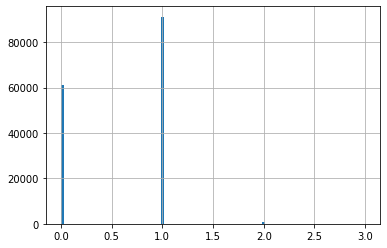

In [4]:
fractionTotal.locationFracOfEmployees.hist(bins = 100)

In [5]:
fractions_byZip = fractions[['gvkey','year','zipcode','locationFracOfEmployees']]
fractions_byZip['year'] =  fractions_byZip['year'].astype('int64')

fractions_byZip = fractions_byZip[(fractions_byZip.year > 2000) & (fractions_byZip.year < 2020)]

print(fractions_byZip.shape)

fractions_byZip.to_csv("../../data/companyData/fractions_byZip.csv")

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(13118248, 4)


In [6]:
del fractions_byZip
del fractionTotal
del fractions
gc.collect()

20

Now merge everything together.

In [85]:
allWeather_withLags = pd.read_csv("../../data/companyData/allWeather_withLags_allZips.csv").drop(columns = {'Unnamed: 0'})
fractions           = pd.read_csv("../../data/companyData/fractions_byZip.csv").drop(columns = {'Unnamed: 0'})

In [87]:
sys.getsizeof(allWeather_withLags)/1e9

1.866355872

In [88]:
sys.getsizeof(fractions)/1e9

0.419784096

In [89]:
def getCompanyWeather(gvkey):
    tempData = fractions[fractions.gvkey == gvkey]

    tempWithWeather  = tempData.merge(allWeather_withLags[allWeather_withLags.zipcode.isin(tempData.zipcode)])
    
    tempWithWeather = pd.concat([tempWithWeather.iloc[:,:6],tempWithWeather.iloc[:,6:].multiply(tempWithWeather.locationFracOfEmployees, axis=0)], axis = 1)
   

    tempWithWeather.drop(columns = {'zipcode', 'locationFracOfEmployees', 'yearQtr'}, inplace = True)
    
    
    tempWithWeather = tempWithWeather.groupby(['gvkey','year','qtr']).sum().reset_index()
    
    
    return(tempWithWeather)

In [80]:
companies = fractions.gvkey.unique()
len(companies)

7710

In [96]:
start = time.time()

weatherWeighted = []

for company in companies:
    weatherWeighted.append(getCompanyWeather(company))
    
    
print(time.time() - start)

227.84374690055847


In [97]:
companyWeighted = pd.concat(weatherWeighted)

companyWeighted

,gvkey,year,qtr,precip_annual_50,precip_annual_95,precip_annual_99,precip_zip_50,precip_zip_95,precip_zip_99,precip_zipQuarter_50,...,lag4_precip_zipQuarter_99,lag4_temp_annual_50,lag4_temp_annual_95,lag4_temp_annual_99,lag4_temp_zip_50,lag4_temp_zip_95,lag4_temp_zip_99,lag4_temp_zipQuarter_50,lag4_temp_zipQuarter_95,lag4_temp_zipQuarter_99
0,3937,2003,1,19.936196,3.007752,0.621944,39.465713,7.006559,1.359571,39.465713,...,1.458557,4.835420,0.000000,0.000000,11.978533,0.000000,0.000000,50.959451,9.096005,0.381634
1,3937,2003,2,29.014311,7.994633,0.382230,43.753727,12.545617,1.645200,43.753727,...,1.571855,59.230173,0.006559,0.000000,70.002385,5.803816,0.006559,54.369112,7.115086,0.364341
2,3937,2003,3,24.054264,9.871199,2.412642,48.538462,13.502087,3.988670,48.538462,...,0.462135,83.056649,3.456172,0.040549,89.478831,26.165176,4.139535,53.601073,5.326178,2.012522
3,3937,2003,4,13.594514,3.115086,0.379845,30.900417,4.737627,0.399523,30.900417,...,1.997615,9.115086,0.000000,0.000000,12.556947,0.000000,0.000000,30.967800,5.872987,3.379845
4,3937,2004,1,11.400119,0.644603,0.002385,28.001193,3.627311,0.002385,28.001193,...,1.359571,3.346452,0.000000,0.000000,5.776386,0.000000,0.000000,34.016100,4.668456,0.017889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,10761,2019,4,8.000000,1.000000,0.000000,26.000000,2.000000,1.000000,26.000000,...,4.000000,24.000000,0.000000,0.000000,18.000000,0.000000,0.000000,33.000000,2.000000,0.000000
0,35354,2019,1,9.000000,0.000000,0.000000,23.000000,1.000000,0.000000,23.000000,...,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,55.000000,6.000000,0.000000
1,35354,2019,2,7.000000,0.000000,0.000000,36.000000,3.000000,0.000000,36.000000,...,0.000000,46.000000,5.000000,2.000000,69.000000,16.000000,6.000000,58.000000,17.000000,7.000000
2,35354,2019,3,6.000000,2.000000,0.000000,21.000000,2.000000,0.000000,21.000000,...,0.000000,80.000000,7.000000,0.000000,90.000000,23.000000,11.000000,56.000000,13.000000,3.000000


In [99]:
for colname in companyWeighted.columns[3:]:
    companyWeighted.rename(columns = {colname: 'empWt_' + colname})

companyWeighted.head()

,gvkey,year,qtr,precip_annual_50,precip_annual_95,precip_annual_99,precip_zip_50,precip_zip_95,precip_zip_99,precip_zipQuarter_50,...,lag4_precip_zipQuarter_99,lag4_temp_annual_50,lag4_temp_annual_95,lag4_temp_annual_99,lag4_temp_zip_50,lag4_temp_zip_95,lag4_temp_zip_99,lag4_temp_zipQuarter_50,lag4_temp_zipQuarter_95,lag4_temp_zipQuarter_99
0,3937,2003,1,19.936196,3.007752,0.621944,39.465713,7.006559,1.359571,39.465713,...,1.458557,4.835420,0.000000,0.000000,11.978533,0.000000,0.000000,50.959451,9.096005,0.381634
1,3937,2003,2,29.014311,7.994633,0.382230,43.753727,12.545617,1.645200,43.753727,...,1.571855,59.230173,0.006559,0.000000,70.002385,5.803816,0.006559,54.369112,7.115086,0.364341
2,3937,2003,3,24.054264,9.871199,2.412642,48.538462,13.502087,3.988670,48.538462,...,0.462135,83.056649,3.456172,0.040549,89.478831,26.165176,4.139535,53.601073,5.326178,2.012522
3,3937,2003,4,13.594514,3.115086,0.379845,30.900417,4.737627,0.399523,30.900417,...,1.997615,9.115086,0.000000,0.000000,12.556947,0.000000,0.000000,30.967800,5.872987,3.379845
4,3937,2004,1,11.400119,0.644603,0.002385,28.001193,3.627311,0.002385,28.001193,...,1.359571,3.346452,0.000000,0.000000,5.776386,0.000000,0.000000,34.016100,4.668456,0.017889


In [100]:
companyWeighted.to_csv("../../data/companyData/weatherByEstablishment.csv")

In [ ]:
establishmentZips = fractions.zipcode.unique()
len(establishmentZips)

--------------------------
# Legacy Code
We'd also looked: by industry, and the moving average streaks.

Now do the same for the industry-specific weather.

In [ ]:
# allWeather = pd.read_csv("../../../../../../../Volumes/backup2/dissData/prism/allWeatherBins_2010.2019.csv").\
allWeather_byInd = pd.read_csv("../../data/companyData/revised_allWeatherBins_2009to2019_byInd.csv").\
    drop(columns = {"Unnamed: 0"})
'''[['famafrench','zipcode','yearQuarter', 
                                    'temp_ffquant_0.95','temp_indQuarterquant_0.95',
                                   'temp5Days_ffquant_0.95', 'temp5Days_indQuarterquant_0.95',
                                   'precip_ffquant_0.95', 'precip_indQuarterquant_0.95',
                                   'precip5Days_ffquant_0.95', 'precip5Days_indQuarterquant_0.95']]
'''
allWeather_byInd['year'] = allWeather_byInd.yearQuarter.str.slice(0,4).astype('int64')
allWeather_byInd['qtr']  = allWeather_byInd.yearQuarter.str.slice(5,6).astype('int64')
allWeather_byInd['yearQtr'] = allWeather_byInd.year + (allWeather_byInd.qtr - 1)/4

allWeather_byInd = allWeather_byInd.astype({'year':       'category',
                         'qtr':        'category',
                         'zipcode':    'category',
                         'famafrench': 'category'})

changes['zipcode'] = changes['zipcode'].astype({'zipcode': 'int64'})

changes = changes.astype({'year':       'category',
                          'qtr':        'category',
                          'zipcode':    'category',
                          'famafrench': 'category'})

col = allWeather_byInd.pop("year")
allWeather_byInd.insert(0, col.name, col)

col = allWeather_byInd.pop("qtr")
allWeather_byInd.insert(0, col.name, col)


col = allWeather_byInd.pop("yearQtr")
allWeather_byInd.insert(0, col.name, col)

allWeather_byInd.drop(columns = {'yearQuarter'}, inplace = True)

print(allWeather_byInd.head())

In [ ]:
lag1 = allWeather_byInd.copy()
lag1['yearQtr'] += 0.25
for colname in lag1.columns[5:]:
    lag1.rename(columns = {colname: 'lag1_' + colname}, inplace = True)
lag1.drop(columns = {'year','qtr'},inplace = True)
lag1 = lag1.astype({'yearQtr':       'category'})

    
lag2 = allWeather_byInd.copy()
lag2['yearQtr'] += 0.5
for colname in lag2.columns[5:]:
    lag2.rename(columns = {colname: 'lag2_' + colname}, inplace = True)
lag2.drop(columns = {'year','qtr'},inplace = True)
lag2 = lag2.astype({'yearQtr':       'category'})


lag3 = allWeather_byInd.copy()
lag3['yearQtr'] += 0.75
for colname in lag3.columns[5:]:
    lag3.rename(columns = {colname: 'lag3_' + colname}, inplace = True)
lag3.drop(columns = {'year','qtr'},inplace = True)
lag3 = lag3.astype({'yearQtr':       'category'})


lag4 = allWeather_byInd.copy()
lag4['yearQtr'] += 1
for colname in lag4.columns[5:]:
    lag4.rename(columns = {colname: 'lag4_' + colname}, inplace = True)
lag4.drop(columns = {'year','qtr'},inplace = True)
lag4 = lag4.astype({'yearQtr':       'category'})


allWeather_byInd = allWeather_byInd.astype({'yearQtr':       'category'})


print(allWeather_byInd.shape)


allWeather_byInd.head()


'''allWeather_byInd_withLags = allWeather_byInd.merge(lag1).merge(lag2).merge(lag3).merge(lag4)

allWeather_byInd_withLags.year.value_counts()
'''

allWeather_byInd_withLags = allWeather_byInd.merge(lag1).merge(lag2).merge(lag3).merge(lag4)

allWeather_byInd_withLags.to_csv("../../data/companyData/allWeather_byInd_withLags.csv")

Now get the streak data. Make sure it's 0/1 for whether there was a streak.

In [ ]:
allWeather = pd.read_csv("../../data/companyData/stockWeather_zipQuarterQuants.csv").\
    drop(columns = {'Unnamed: 0'})

allWeather = allWeather[~allWeather.temp_zipQuarterLast5.isna()].reset_index(drop = True)

allWeather['date'] = pd.to_datetime(allWeather['date'],
                                   format = "%Y-%m-%d")

allWeather['hotStreak']   = (allWeather['temp_zipQuarterLast5'] == 5)*1
allWeather['wetStreak'] = (allWeather['precip_zipQuarterLast5'] == 5)*1

allWeather.rename(columns = {'ZIP': 'zipcode'}, inplace = True)
print(allWeather.dtypes)

allWeather['year'] = allWeather.date.dt.year
allWeather['quarter'] = allWeather.date.dt.quarter


allWeather.drop(columns = {'date','temp_zipQuarterLast5','precip_zipQuarterLast5'}, inplace = True)

streaks = allWeather.groupby(['zipcode','year','quarter']).sum().reset_index()

streaks['hotStreak'] = (streaks['hotStreak'] > 0)*1
streaks['wetStreak'] = (streaks['wetStreak'] > 0)*1

streaks.rename(columns = {'quarter': 'qtr'}, inplace = True)
streaks.head()

streaks['yearQtr'] = streaks.year + (streaks.qtr - 1)/4

col = streaks.pop("yearQtr")
streaks.insert(0, col.name, col)

lag1 = streaks.copy()
lag1['yearQtr'] += 0.25
for colname in lag1.columns[4:]:
    lag1.rename(columns = {colname: 'lag1_' + colname}, inplace = True)
lag1.drop(columns = {'year','qtr'},inplace = True)

    
lag2 = streaks.copy()
lag2['yearQtr'] += 0.5
for colname in lag2.columns[4:]:
    lag2.rename(columns = {colname: 'lag2_' + colname}, inplace = True)
lag2.drop(columns = {'year','qtr'},inplace = True)


lag3 = streaks.copy()
lag3['yearQtr'] += 0.75
for colname in lag3.columns[4:]:
    lag3.rename(columns = {colname: 'lag3_' + colname}, inplace = True)
lag3.drop(columns = {'year','qtr'},inplace = True)


lag4 = streaks.copy()
lag4['yearQtr'] += 1
for colname in lag4.columns[4:]:
    lag4.rename(columns = {colname: 'lag4_' + colname}, inplace = True)
lag4.drop(columns = {'year','qtr'},inplace = True)


print(streaks.shape)

streaks_withLags = streaks.merge(lag1).merge(lag2).merge(lag3).merge(lag4)

print(streaks_withLags.year.value_counts())

streaks_withLags.to_csv("../../data/companyData/streaks_withLags.csv")
